# Phage One-Step Growth Case Study

This example uses the model developed in the paper: https://www.biorxiv.org/content/10.1101/2025.05.15.651590v1

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import sys
import scipy.io
from concurrent.futures import ProcessPoolExecutor

# Get path 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)




In [2]:
import sys
sys.path.append('./..')  # or absolute path if needed

from invode import ODEOptimizer, lhs_sample, load_matlab_data

In [3]:
'''
file_path = './../sample_data/HS6_13-15_2024.mat' 
free_phages = load_matlab_data(file_path)['free_phages']
S0 = np.mean(load_matlab_data(file_path)['S0_replicates'])
V0 = np.mean(load_matlab_data(file_path)['V0_replicates'])
time = load_matlab_data(file_path)['time_free_phages'].flatten()/60  # Convert time to hours
'''



free_phages = np.array([[   13200,    13500,    15400],
       [   15500,    11800,    14450],
       [   17200,    13100,    15000],
       [   12100,    13000,    14500],
       [   16700,    12900,    13500],
       [  194000,    60000,    67000],
       [ 2860000,  1280000,  1410000],
       [12200000, 11100000, 10100000],
       [42000000, 27300000, 25350000],
       [49000000, 53000000, 47000000],
       [58500000, 50500000, 61000000],
       [42500000, 33000000, 44000000]])

time = np.array([0.        , 0.33333333, 0.66666667, 1.        , 1.16666667,
       1.33333333, 1.5       , 1.66666667, 1.83333333, 2.        ,
       2.33333333, 2.66666667])

S0 = 128906002
V0 = np.mean(free_phages[:,0])

In [4]:
'''

# Initial guess for parameters ===
initial_guess = {
    'r': 0.3,
    'phi': 4.5e-08 ,
    'beta':  256,
    'tau': 2,
    'NE': 180
}


# Initial conditions ===
y0 = np.zeros((initial_guess['NE']+3,))
y0[0] = S0
y0[-1] = V0
'''

"\n\n# Initial guess for parameters ===\ninitial_guess = {\n    'r': 0.3,\n    'phi': 4.5e-08 ,\n    'beta':  256,\n    'tau': 2,\n    'NE': 180\n}\n\n\n# Initial conditions ===\ny0 = np.zeros((initial_guess['NE']+3,))\ny0[0] = S0\ny0[-1] = V0\n"

In [5]:
def onstep(y, t, params):

    phi = params['phi']
    beta = params['beta']
    tau = params['tau']
    r = params['r']
    NE = params['NE']

    S = y[0]
    E_mat = y[1:NE+1]
    I = y[NE+1]
    V = y[NE+2]

    etaeff = ((NE+1)/tau)

    dotS = r*S - phi*V*S
    dotE1 = phi*S*V - etaeff * E_mat[0]
    
    if NE > 1:
        dotE_mat = np.zeros(NE-1)
        dotE_mat[:] = etaeff * E_mat[0:-1] - etaeff * E_mat[1:]

    dotI = etaeff * (E_mat[-1] - I)
    dotV = beta * etaeff * I - V * phi * (S + I + np.sum(E_mat))

    # Build the full derivative vector (same length as y)
    dydt = np.zeros_like(y)
    dydt[0] = dotS
    dydt[1:NE+1] = dotE1 if NE == 1 else np.concatenate([[dotE1], dotE_mat])
    dydt[NE+1] = dotI
    dydt[NE+2] = dotV

    return dydt



In [6]:
def simulate_model(params):
    # Initial conditions ===
    params['NE'] = int(params['NE'])
    y0 = np.zeros((params['NE']+3,))
    y0[0] = S0
    y0[-1] = V0


    ## dilution step
    time_dil = np.linspace(0, 0.25, 200)  # Short time for dilution step
    sol_dil = odeint(onstep, y0, time_dil, args=(params,))
    y0_dil = sol_dil[-1, :]/100 # Use the last state as the new initial condition
    ## main simulation
    sol = odeint(onstep, y0_dil, time, args=(params,))
    phage_solution = sol[:,-1]
    return phage_solution 



In [7]:
def mse(model_output):
    target = np.mean(free_phages, axis=1)
    if len(model_output) != len(target):
        raise ValueError("Length mismatch between model output and data")
    return np.mean((np.log10(model_output) - np.log10(target)) ** 2)


In [8]:
#free_phages_sol = simulate_model(initial_guess)

In [9]:

param_bounds = {
    'r': 0.3,  # fixed
    'phi': (1e-8, 1e-7),
    'beta': (100, 500),
    'tau': (1, 5),
    'NE': (100, 200)
}


optimizer = ODEOptimizer(
    ode_func=simulate_model,
    error_func=mse,
    param_bounds=param_bounds,
    #initial_guess=initial_guess,
    seed=42,
    num_top_candidates=2,
    n_samples=100,
    num_iter=5,
    verbose_plot=True,
    verbose = True
)



Fitting Progress:   0%|                                                           | 0/5 [00:00<?, ?it/s]


Iteration 1/5


Fitting Progress:  20%|██████████▏                                        | 1/5 [00:00<00:03,  1.02it/s]

Best error so far: 0.1183
Best params: {'phi': 4.266983966023513e-08, 'beta': 377.39952281604735, 'tau': 2.0208683819873485, 'NE': 157, 'r': 0.3}

Iteration 2/5


Fitting Progress:  40%|████████████████████▍                              | 2/5 [00:03<00:06,  2.02s/it]

Best error so far: 0.0041
Best params: {'phi': 7.00989772815266e-08, 'beta': 391.1287225045886, 'tau': 1.9741647732052143, 'NE': 163, 'r': 0.3}

Iteration 3/5


Fitting Progress:  60%|██████████████████████████████▌                    | 3/5 [00:06<00:04,  2.47s/it]

Best error so far: 0.0041
Best params: {'phi': 7.00989772815266e-08, 'beta': 391.1287225045886, 'tau': 1.9741647732052143, 'NE': 163, 'r': 0.3}

Iteration 4/5


Fitting Progress:  80%|████████████████████████████████████████▊          | 4/5 [00:09<00:02,  2.64s/it]

Best error so far: 0.0041
Best params: {'phi': 7.00989772815266e-08, 'beta': 391.1287225045886, 'tau': 1.9741647732052143, 'NE': 163, 'r': 0.3}

Iteration 5/5


Fitting Progress: 100%|███████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]

Best error so far: 0.0041
Best params: {'phi': 7.00989772815266e-08, 'beta': 391.1287225045886, 'tau': 1.9741647732052143, 'NE': 163, 'r': 0.3}
Refining params: {'phi': 7.013988205829579e-08, 'beta': 348.49148227932295, 'tau': 1.9239617327028835, 'NE': 173}



[Local Optimization]
Refined parameters: {'phi': 6.823759283454945e-08, 'beta': 348.4914781187379, 'tau': 1.9422442211934774, 'NE': 173.0, 'r': 0.3}
Refined error: 0.004188937021152051
Refining params: {'phi': 7.158050791552344e-08, 'beta': 445.2424565642069, 'tau': 1.9461328394135549, 'NE': 154}

[Local Optimization]
Local optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH
After local refinement:
Best params: {'phi': 6.823759283454945e-08, 'beta': 348.4914781187379, 'tau': 1.9422442211934774, 'NE': 173.0, 'r': 0.3}
Best error: 0.0042


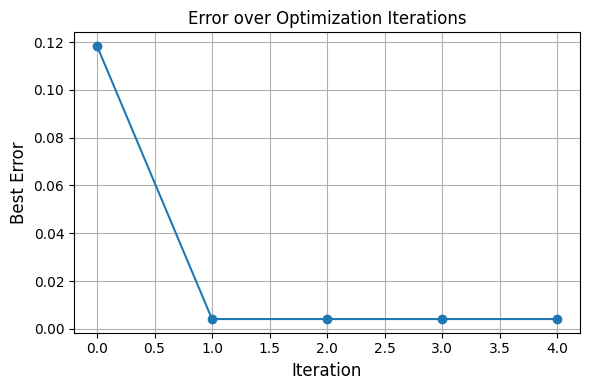

({'phi': 6.823759283454945e-08,
  'beta': 348.4914781187379,
  'tau': 1.9422442211934774,
  'NE': 173.0,
  'r': 0.3},
 0.004188937021152051)

In [10]:

optimizer.fit()


In [11]:
best_params = optimizer.best_params


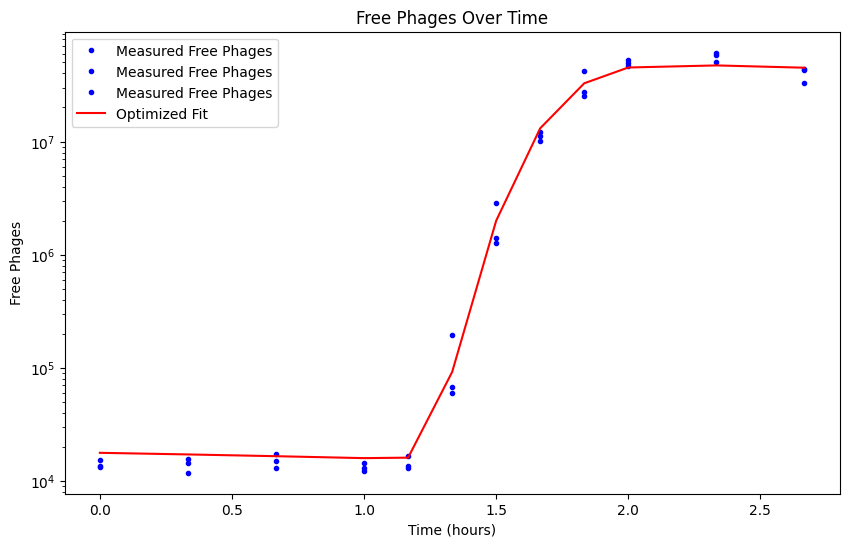

In [12]:
phages_fit = simulate_model(best_params)


plt.figure(figsize=(10, 6))
plt.plot(time, free_phages, label='Measured Free Phages', color='blue', marker='o', markersize=3, linestyle='none')
#plt.plot(time, free_phages_sol, label='Initial Guess', linestyle='--', color='orange')
plt.plot(time, phages_fit, label='Optimized Fit', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Free Phages')
plt.yscale('log')
plt.title('Free Phages Over Time')
plt.legend()
plt.show()

In [13]:
optimizer.summary()

🔍 ODEOptimizer Summary:
  ode_func: simulate_model
  error_func: mse
  param_bounds: {'phi': (1e-08, 1e-07), 'beta': (100, 500), 'tau': (1, 5), 'NE': (100, 200)}
  initial_guess: {'phi': 5.4999999999999996e-08, 'beta': 300.0, 'tau': 3.0, 'NE': 150.0, 'r': 0.3}
  n_samples: 100
  num_iter: 5
  num_top_candidates: 2
  do_local_opt: True
  local_method: L-BFGS-B
  shrink_rate: 0.5
  parallel: False
  local_parallel: False
  verbose: True
  verbose_plot: True
  seed: 42
  best_error: 0.004188937021152051
  best_params: {'phi': 6.823759283454945e-08, 'beta': 348.4914781187379, 'tau': 1.9422442211934774, 'NE': 173, 'r': 0.3}


In [14]:
df = optimizer.get_top_candidates_table()
print(df)

   iteration  rank     error           phi        beta       tau   NE    r
0          1     1  0.118342  4.266984e-08  377.399523  2.020868  157  0.3
1          1     2  0.131130  4.917636e-08  334.668375  2.045617  168  0.3
2          2     1  0.004130  7.009898e-08  391.128723  1.974165  163  0.3
3          2     2  0.006739  6.835375e-08  294.076868  1.907686  190  0.3
4          3     1  0.005034  7.649504e-08  442.555402  1.990015  153  0.3
5          3     2  0.014846  8.143537e-08  292.647566  1.947413  182  0.3
6          4     1  0.016187  6.538001e-08  242.538774  1.912211  168  0.3
7          4     2  0.020552  8.440974e-08  361.452366  1.934187  158  0.3
8          5     1  0.005695  7.013988e-08  348.491482  1.923962  173  0.3
9          5     2  0.014288  7.158051e-08  445.242457  1.946133  154  0.3
